In [1]:
import sys
import tensorflow.keras
import tensorflow as tf

print(f"tensorflow version : {tf.__version__}")
# print(f"keras version : {tensorflow.keras.__version__}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is " , "Available" if gpu else "NOT available")

tensorflow version : 2.13.0
GPU is  Available


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.metrics import precision_score
from tensorflow.keras import regularizers
import shutil
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D, Flatten, Dense
from keras.layers import Conv2D , GlobalAveragePooling2D , MaxPooling2D,Dropout , Flatten , Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.framework.func_graph import flatten
from keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.applications.inception_v3 import  preprocess_input
from sklearn.model_selection import KFold
from keras.callbacks import Callback

In [3]:
import os

root_dir = "data"
number_of_images = {}

for dir in os.listdir(root_dir):
    # Ignore .DS_Store files
    if dir == '.DS_Store':
        continue

    # Check if the item is a directory before listing its contents
    if os.path.isdir(os.path.join(root_dir, dir)):
        number_of_images[dir] = len(os.listdir(os.path.join(root_dir, dir)))

print(number_of_images.items())


dict_items([('cat', 5000), ('dog', 5000), ('truck', 5000), ('bird', 5000), ('airplane', 5000), ('ship', 5000), ('frog', 5000), ('horse', 5000), ('deer', 5000), ('automobile', 5000)])


In [4]:
def foldercreation (path , split) :
    if not os.path.exists('./'+path):
      os.mkdir('./'+path)

      for dir in os.listdir(root_dir):
        if dir == '.DS_Store':
           continue
            
        os.makedirs('./'+path+"/"+dir)

        for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)) , size = (math.floor(split * number_of_images[dir])-5) , replace=False):
          Original = os.path.join(root_dir,dir,img)
          Destination =os.path.join('./'+path , dir)
          shutil.copy(Original,Destination)
          # os.remove(Original)

    else:
      print("The folder exsist")

In [5]:
foldercreation("train_data",0.7)
foldercreation("validation_data",0.15)
foldercreation("test_data",0.15)

The folder exsist
The folder exsist
The folder exsist


In [6]:
image_data = ImageDataGenerator (
                                     
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      preprocessing_function= preprocess_input,
                                )

image=image_data.flow_from_directory(directory="train_data" ,
                                       target_size=(28,28),
                                       batch_size=32,
                                       shuffle=True,
                                       class_mode="categorical")

Found 34950 images belonging to 10 classes.


In [7]:
def preprocessing2 (path):
  image_data = ImageDataGenerator(preprocessing_function= preprocess_input)
  image = image_data.flow_from_directory(directory = path,
                                         target_size=(28,28),
                                         batch_size = 32,
                                         shuffle=True,
                                         class_mode = "categorical")
  return image

In [8]:
path_test ="test_data"
test_data = preprocessing2(path_test)
X_test , Y_test = test_data.next()

Found 7450 images belonging to 10 classes.


In [9]:
path_validate="validation_data"
validate_data = preprocessing2(path_validate)
validate_data_1 , validate_labels = validate_data.next()

Found 7450 images belonging to 10 classes.


In [10]:
softplus = tf.nn.softplus
def model_layer_1 (inputs,filters):


  convo_2x2 = Conv2D(filters=filters[0], kernel_size=(2,2), padding='same', activation='softplus')(inputs)
  convo_3x3 = Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='softplus')(inputs)
  pool_conv = Conv2D(filters=filters[2], kernel_size=(3,3), padding='same', activation='softplus')(inputs)


  outputs = Concatenate(axis=-1)([convo_2x2, convo_3x3, pool_conv])

  return outputs


def model_layer_2 (inputs,filters):



  convo_3x3 = Conv2D(filters=filters[0], kernel_size=(2,2), padding='same', activation='softplus')(inputs)
  pool_3x3 =MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(convo_3x3)

  convo_5x5 = Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='softplus')(inputs)
  pool_5x5 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(convo_5x5)

  outputs = Concatenate(axis=-1)([pool_3x3, pool_5x5])

  return outputs


def model_layer_3 (inputs,filters):
    
  convo_1x1 = Conv2D(filters=filters[0], kernel_size=(3,3), padding='same', activation='softplus')(inputs)
  pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
  outputs = Concatenate(axis=-1)([pool_1x1, convo_1x1])

  return outputs


# def model_layer_5 (inputs,filters):
    
#   convo_1x1 = Conv2D(filters=filters[0], kernel_size=(5,5), padding='same', activation='relu')(inputs)
#   pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
#   outputs = Concatenate(axis=-1)([pool_1x1, convo_1x1])

#   return outputs

# def model_layer_6 (inputs):
    
#   pool_3x3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(inputs)
#   pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
#   outputs = Concatenate(axis=-1)([pool_1x1, pool_3x3])

#   return outputs

    




In [11]:
from keras.layers import Input
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

# define input tensor

input_tensor = Input(shape=(28, 28, 3))


original_model = model_layer_3(input_tensor,[128])
original_model = MaxPooling2D(pool_size=(2,2) ,padding='same')(original_model)


original_model = model_layer_1(original_model,[32,64,128])
original_model = MaxPooling2D(pool_size=(2,2),padding='same')(original_model)
original_model = model_layer_2(original_model,[128,64])

original_model = MaxPooling2D(pool_size=(2,2) ,padding='same')(original_model)
original_model = model_layer_3(original_model,[128])




2023-12-20 12:40:11.302663: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-20 12:40:11.302694: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-20 12:40:11.302706: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-20 12:40:11.302741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-20 12:40:11.302763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:

original_model = Flatten()(original_model)
original_model = Dense(512, activation='softplus' ,kernel_regularizer=regularizers.l2(0.001))(original_model)
original_model = Dense(256, activation='softplus' ,kernel_regularizer=regularizers.l2(0.001))(original_model)
original_model = Dropout(0.5)(original_model)

output_tensor = Dense(10, activation='softmax' ,kernel_regularizer=regularizers.l2(0.001))(original_model)

original_model = Model(inputs=input_tensor, outputs=output_tensor)

In [13]:
original_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 28, 28, 3)            0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 28, 28, 131)          0         ['max_pooling2d[0][0]',   

In [14]:
opt = keras.optimizers.Adam()
original_model.compile(optimizer= opt ,
              loss= keras.losses.categorical_crossentropy,
              metrics=['accuracy' , 'AUC'])

In [15]:
earlystop = EarlyStopping(monitor="accuracy",
                          min_delta=0.01 , patience=3,
                          verbose=1,
                          mode="auto")
modelcheckpoint = ModelCheckpoint(monitor="accuracy",
                                  filepath = "./softplus.h5",
                                  verbose=1,
                                  save_best_only=True,
                                  mode ="auto"
                                  )
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-3)


class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data[0], self.validation_data[1]
        predictions = self.model.predict(x_val)
        
        # Calculate top-5 accuracy
        top_5 = np.argsort(predictions, axis=1)[:, -5:]
        true_labels = np.argmax(y_val, axis=1)
        top_5_accuracy = np.mean([1 if true_label in pred_classes else 0 for true_label, pred_classes in zip(true_labels, top_5)])
        
        # Calculate precision
        precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
        
        print(f'Epoch {epoch + 1} - Top-5 Accuracy: {top_5_accuracy:.4f} - Precision: {precision:.4f}')


metrics_callback = MetricsCallback(validation_data=(validate_data_1, validate_labels))

callbs = [earlystop,modelcheckpoint,lr_scheduler,metrics_callback]

In [16]:
final = original_model.fit(
    image,
    steps_per_epoch=len(image),
    epochs=30,
    validation_data=(validate_data_1, validate_labels),
    validation_steps=len(validate_data_1),
    verbose=1,
    callbacks=callbs)
    

Epoch 1/30


2023-12-20 12:40:13.050160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1093/1093 [==============================] - ETA: 0s - loss: 2.6527 - accuracy: 0.1559 - auc: 0.6143

2023-12-20 12:42:24.654195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.15591, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 234ms/step
Epoch 1 - Top-5 Accuracy: 0.8125 - Precision: 0.2231
1093/1093 [==============================] - 135s 122ms/step - loss: 2.6527 - accuracy: 0.1559 - auc: 0.6143 - val_loss: 2.1489 - val_accuracy: 0.2812 - val_auc: 0.7374 - lr: 0.0010
Epoch 2/30


2023-12-20 12:42:27.129336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.8302 - accuracy: 0.3635 - auc: 0.8197
Epoch 2: accuracy improved from 0.15591 to 0.36349, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 95ms/step
Epoch 2 - Top-5 Accuracy: 0.9688 - Precision: 0.4802
1093/1093 [==============================] - 131s 119ms/step - loss: 1.8302 - accuracy: 0.3635 - auc: 0.8197 - val_loss: 1.5179 - val_accuracy: 0.4688 - val_auc: 0.8911 - lr: 0.0010
Epoch 3/30
1093/1093 [==============================] - ETA: 0s - loss: 1.6337 - accuracy: 0.4355 - auc: 0.8584
Epoch 3: accuracy improved from 0.36349 to 0.43554, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 127ms/step
Epoch 3 - Top-5 Accuracy: 0.9375 - Precision: 0.5052
1093/1093 [==============================] - 130s 119ms/step - loss: 1.6337 - accuracy: 0.4355 - auc: 0.8584 - val_loss: 1.5163 - val_accuracy: 0.4688 - val_auc: 0.8807 - lr: 0.0010
Epoch 4/30
1093/1093 [==============================] - ETA: 0s - loss: 1.5376 - accuracy: 0.4694 - auc: 0.8752
Epoch 4: accuracy improved from 0.43554 to 0.46938, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 92ms/step
Epoch 4 - Top-5 Accuracy: 0.9688 - Precision: 0.4365
1093/1093 [==============================] - 131s 119ms/step - loss: 1.5376 - accuracy: 0.4694 - auc: 0.8752 - val_loss: 1.4856 - val_accuracy: 0.4375 - val_auc: 0.8898 - lr: 0.0010
Epoch 5/30
   1/1093 [..............................] - ETA: 3:10 - loss: 1.5747 - accuracy: 0.5000 - auc: 0.8726

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.4790 - accuracy: 0.4943 - auc: 0.8855
Epoch 5: accuracy improved from 0.46938 to 0.49431, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 86ms/step
Epoch 5 - Top-5 Accuracy: 0.9688 - Precision: 0.4851
1093/1093 [==============================] - 139s 127ms/step - loss: 1.4790 - accuracy: 0.4943 - auc: 0.8855 - val_loss: 1.3960 - val_accuracy: 0.4375 - val_auc: 0.9085 - lr: 0.0010
Epoch 6/30
1093/1093 [==============================] - ETA: 0s - loss: 1.4296 - accuracy: 0.5105 - auc: 0.8938
Epoch 6: accuracy improved from 0.49431 to 0.51047, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 80ms/step
Epoch 6 - Top-5 Accuracy: 0.9688 - Precision: 0.5052
1093/1093 [==============================] - 147s 134ms/step - loss: 1.4296 - accuracy: 0.5105 - auc: 0.8938 - val_loss: 1.3741 - val_accuracy: 0.4688 - val_auc: 0.9124 - lr: 0.0010
Epoch 7/30
1093/1093 [==============================] - ETA: 0s - loss: 1.3938 - accuracy: 0.5278 - auc: 0.8998
Epoch 7: accuracy improved from 0.51047 to 0.52778, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 113ms/step
Epoch 7 - Top-5 Accuracy: 0.9375 - Precision: 0.6042
1093/1093 [==============================] - 130s 119ms/step - loss: 1.3938 - accuracy: 0.5278 - auc: 0.8998 - val_loss: 1.2681 - val_accuracy: 0.5938 - val_auc: 0.9199 - lr: 0.0010
Epoch 8/30
1093/1093 [==============================] - ETA: 0s - loss: 1.3607 - accuracy: 0.5409 - auc: 0.9053
Epoch 8: accuracy improved from 0.52778 to 0.54092, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 97ms/step
Epoch 8 - Top-5 Accuracy: 1.0000 - Precision: 0.5260
1093/1093 [==============================] - 124s 113ms/step - loss: 1.3607 - accuracy: 0.5409 - auc: 0.9053 - val_loss: 1.4258 - val_accuracy: 0.5312 - val_auc: 0.8985 - lr: 0.0010
Epoch 9/30
1093/1093 [==============================] - ETA: 0s - loss: 1.3188 - accuracy: 0.5588 - auc: 0.9110
Epoch 9: accuracy improved from 0.54092 to 0.55877, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 105ms/step
Epoch 9 - Top-5 Accuracy: 0.9688 - Precision: 0.5776
1093/1093 [==============================] - 123s 112ms/step - loss: 1.3188 - accuracy: 0.5588 - auc: 0.9110 - val_loss: 1.2822 - val_accuracy: 0.6250 - val_auc: 0.9229 - lr: 0.0010
Epoch 10/30
1093/1093 [==============================] - ETA: 0s - loss: 1.3015 - accuracy: 0.5664 - auc: 0.9146
Epoch 10: accuracy improved from 0.55877 to 0.56638, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 98ms/step
Epoch 10 - Top-5 Accuracy: 0.9688 - Precision: 0.5521
1093/1093 [==============================] - 134s 122ms/step - loss: 1.3015 - accuracy: 0.5664 - auc: 0.9146 - val_loss: 1.2507 - val_accuracy: 0.5938 - val_auc: 0.9280 - lr: 0.0010
Epoch 11/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2710 - accuracy: 0.5791 - auc: 0.9184
Epoch 11: accuracy improved from 0.56638 to 0.57908, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 78ms/step
Epoch 11 - Top-5 Accuracy: 1.0000 - Precision: 0.7188
1093/1093 [==============================] - 142s 130ms/step - loss: 1.2710 - accuracy: 0.5791 - auc: 0.9184 - val_loss: 1.2013 - val_accuracy: 0.6562 - val_auc: 0.9339 - lr: 0.0010
Epoch 12/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2533 - accuracy: 0.5842 - auc: 0.9205
Epoch 12: accuracy improved from 0.57908 to 0.58418, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 59ms/step
Epoch 12 - Top-5 Accuracy: 0.9375 - Precision: 0.5260
1093/1093 [==============================] - 146s 134ms/step - loss: 1.2533 - accuracy: 0.5842 - auc: 0.9205 - val_loss: 1.4368 - val_accuracy: 0.5625 - val_auc: 0.8937 - lr: 0.0010
Epoch 13/30
   1/1093 [..............................] - ETA: 2:49 - loss: 1.4754 - accuracy: 0.5000 - auc: 0.8917

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.2231 - accuracy: 0.5933 - auc: 0.9247
Epoch 13: accuracy improved from 0.58418 to 0.59328, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 52ms/step
Epoch 13 - Top-5 Accuracy: 0.9062 - Precision: 0.5781
1093/1093 [==============================] - 97s 89ms/step - loss: 1.2231 - accuracy: 0.5933 - auc: 0.9247 - val_loss: 1.3240 - val_accuracy: 0.5938 - val_auc: 0.9000 - lr: 0.0010
Epoch 14/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2026 - accuracy: 0.6029 - auc: 0.9275
Epoch 14: accuracy improved from 0.59328 to 0.60295, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 60ms/step
Epoch 14 - Top-5 Accuracy: 1.0000 - Precision: 0.5589
1093/1093 [==============================] - 104s 95ms/step - loss: 1.2026 - accuracy: 0.6029 - auc: 0.9275 - val_loss: 1.3079 - val_accuracy: 0.5938 - val_auc: 0.9199 - lr: 0.0010
Epoch 15/30
1093/1093 [==============================] - ETA: 0s - loss: 1.1828 - accuracy: 0.6074 - auc: 0.9305
Epoch 15: accuracy improved from 0.60295 to 0.60738, saving model to ./softplus.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 70ms/step
Epoch 15 - Top-5 Accuracy: 0.9688 - Precision: 0.4792
1093/1093 [==============================] - 87s 79ms/step - loss: 1.1828 - accuracy: 0.6074 - auc: 0.9305 - val_loss: 1.2274 - val_accuracy: 0.5312 - val_auc: 0.9266 - lr: 0.0010
Epoch 16/30
1093/1093 [==============================] - ETA: 0s - loss: 1.1642 - accuracy: 0.6151 - auc: 0.9326
Epoch 16: accuracy improved from 0.60738 to 0.61505, saving model to ./softplus.h5
1/1 [==============================] - 0s 40ms/step
Epoch 16 - Top-5 Accuracy: 0.9375 - Precision: 0.6250
1093/1093 [==============================] - 74s 67ms/step - loss: 1.1642 - accuracy: 0.6151 - auc: 0.9326 - val_loss: 1.2227 - val_accuracy: 0.6250 - val_auc: 0.9274 - lr: 0.0010
Epoch 17/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.1422 - accuracy: 0.6281 - auc: 0.9358
Epoch 17: accuracy improved from 0.61505 to 0.62807, saving model to ./softplus.h5
1/1 [==============================] - 0s 41ms/step
Epoch 17 - Top-5 Accuracy: 0.9688 - Precision: 0.7083
1093/1093 [==============================] - 65s 60ms/step - loss: 1.1422 - accuracy: 0.6281 - auc: 0.9358 - val_loss: 1.0943 - val_accuracy: 0.6562 - val_auc: 0.9419 - lr: 0.0010
Epoch 18/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.1215 - accuracy: 0.6355 - auc: 0.9377
Epoch 18: accuracy improved from 0.62807 to 0.63554, saving model to ./softplus.h5
1/1 [==============================] - 0s 40ms/step
Epoch 18 - Top-5 Accuracy: 0.9375 - Precision: 0.6797
1093/1093 [==============================] - 67s 61ms/step - loss: 1.1215 - accuracy: 0.6355 - auc: 0.9377 - val_loss: 1.1162 - val_accuracy: 0.6250 - val_auc: 0.9398 - lr: 0.0010
Epoch 19/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.0984 - accuracy: 0.6415 - auc: 0.9404
Epoch 19: accuracy improved from 0.63554 to 0.64146, saving model to ./softplus.h5
1/1 [==============================] - 0s 34ms/step
Epoch 19 - Top-5 Accuracy: 0.9062 - Precision: 0.6125
1093/1093 [==============================] - 53s 49ms/step - loss: 1.0984 - accuracy: 0.6415 - auc: 0.9404 - val_loss: 1.1402 - val_accuracy: 0.5625 - val_auc: 0.9347 - lr: 0.0010
Epoch 20/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.0884 - accuracy: 0.6497 - auc: 0.9418
Epoch 20: accuracy improved from 0.64146 to 0.64973, saving model to ./softplus.h5
1/1 [==============================] - 0s 48ms/step
Epoch 20 - Top-5 Accuracy: 0.9688 - Precision: 0.5052
1093/1093 [==============================] - 58s 53ms/step - loss: 1.0884 - accuracy: 0.6497 - auc: 0.9418 - val_loss: 1.3243 - val_accuracy: 0.5625 - val_auc: 0.9247 - lr: 0.0010
Epoch 21/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.0787 - accuracy: 0.6541 - auc: 0.9431
Epoch 21: accuracy improved from 0.64973 to 0.65413, saving model to ./softplus.h5
1/1 [==============================] - 0s 54ms/step
Epoch 21 - Top-5 Accuracy: 0.9688 - Precision: 0.6042
1093/1093 [==============================] - 71s 65ms/step - loss: 1.0787 - accuracy: 0.6541 - auc: 0.9431 - val_loss: 1.0708 - val_accuracy: 0.6250 - val_auc: 0.9492 - lr: 0.0010
Epoch 22/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.0571 - accuracy: 0.6612 - auc: 0.9454
Epoch 22: accuracy improved from 0.65413 to 0.66123, saving model to ./softplus.h5
1/1 [==============================] - 0s 39ms/step
Epoch 22 - Top-5 Accuracy: 1.0000 - Precision: 0.6214
1093/1093 [==============================] - 72s 66ms/step - loss: 1.0571 - accuracy: 0.6612 - auc: 0.9454 - val_loss: 1.0937 - val_accuracy: 0.6250 - val_auc: 0.9462 - lr: 0.0010
Epoch 23/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.6629 - auc: 0.9469
Epoch 23: accuracy improved from 0.66123 to 0.66295, saving model to ./softplus.h5
1/1 [==============================] - 0s 46ms/step
Epoch 23 - Top-5 Accuracy: 1.0000 - Precision: 0.6042
1093/1093 [==============================] - 72s 66ms/step - loss: 1.0398 - accuracy: 0.6629 - auc: 0.9469 - val_loss: 1.0973 - val_accuracy: 0.5938 - val_auc: 0.9457 - lr: 0.0010
Epoch 24/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.0240 - accuracy: 0.6737 - auc: 0.9487
Epoch 24: accuracy improved from 0.66295 to 0.67373, saving model to ./softplus.h5
1/1 [==============================] - 0s 37ms/step
Epoch 24 - Top-5 Accuracy: 0.9375 - Precision: 0.5813
1093/1093 [==============================] - 62s 56ms/step - loss: 1.0240 - accuracy: 0.6737 - auc: 0.9487 - val_loss: 1.0775 - val_accuracy: 0.5938 - val_auc: 0.9437 - lr: 0.0010
Epoch 25/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.0142 - accuracy: 0.6772 - auc: 0.9501
Epoch 25: accuracy improved from 0.67373 to 0.67722, saving model to ./softplus.h5
1/1 [==============================] - 0s 38ms/step
Epoch 25 - Top-5 Accuracy: 0.9375 - Precision: 0.6635
1093/1093 [==============================] - 60s 55ms/step - loss: 1.0142 - accuracy: 0.6772 - auc: 0.9501 - val_loss: 0.9571 - val_accuracy: 0.6875 - val_auc: 0.9563 - lr: 0.0010
Epoch 26/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1092/1093 [============================>.] - ETA: 0s - loss: 0.9924 - accuracy: 0.6816 - auc: 0.9520
Epoch 26: accuracy improved from 0.67722 to 0.68157, saving model to ./softplus.h5
1/1 [==============================] - 0s 36ms/step
Epoch 26 - Top-5 Accuracy: 0.9375 - Precision: 0.6354
1093/1093 [==============================] - 61s 55ms/step - loss: 0.9925 - accuracy: 0.6816 - auc: 0.9520 - val_loss: 0.9230 - val_accuracy: 0.6562 - val_auc: 0.9604 - lr: 0.0010
Epoch 27/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.6844 - auc: 0.9522
Epoch 27: accuracy improved from 0.68157 to 0.68443, saving model to ./softplus.h5
1/1 [==============================] - 0s 35ms/step
Epoch 27 - Top-5 Accuracy: 0.9688 - Precision: 0.7005
1093/1093 [==============================] - 60s 55ms/step - loss: 0.9872 - accuracy: 0.6844 - auc: 0.9522 - val_loss: 0.9996 - val_accuracy: 0.7188 - val_auc: 0.9545 - lr: 0.0010
Epoch 28/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.9753 - accuracy: 0.6915 - auc: 0.9540
Epoch 28: accuracy improved from 0.68443 to 0.69147, saving model to ./softplus.h5
1/1 [==============================] - 0s 36ms/step
Epoch 28 - Top-5 Accuracy: 0.9688 - Precision: 0.6771
1093/1093 [==============================] - 60s 55ms/step - loss: 0.9753 - accuracy: 0.6915 - auc: 0.9540 - val_loss: 1.0254 - val_accuracy: 0.6562 - val_auc: 0.9430 - lr: 0.0010
Epoch 29/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 0.9680 - accuracy: 0.6960 - auc: 0.9550
Epoch 29: accuracy improved from 0.69147 to 0.69599, saving model to ./softplus.h5
1/1 [==============================] - 0s 30ms/step
Epoch 29 - Top-5 Accuracy: 1.0000 - Precision: 0.6323
1093/1093 [==============================] - 60s 55ms/step - loss: 0.9680 - accuracy: 0.6960 - auc: 0.9550 - val_loss: 1.0191 - val_accuracy: 0.6562 - val_auc: 0.9531 - lr: 0.0010
Epoch 30/30
   1/1093 [..............................] - ETA: 1:17 - loss: 1.2042 - accuracy: 0.6562 - auc: 0.9349

/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.9513 - accuracy: 0.6980 - auc: 0.9565
Epoch 30: accuracy improved from 0.69599 to 0.69797, saving model to ./softplus.h5
1/1 [==============================] - 0s 31ms/step
Epoch 30 - Top-5 Accuracy: 0.9688 - Precision: 0.7437
1093/1093 [==============================] - 53s 48ms/step - loss: 0.9513 - accuracy: 0.6980 - auc: 0.9565 - val_loss: 1.0635 - val_accuracy: 0.6875 - val_auc: 0.9467 - lr: 0.0010


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
image.class_indices

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [18]:
import numpy as np
from sklearn.metrics import precision_score

def calculate_metrics(true_labels, predictions):
    # Calculate top-5 accuracy
    top_5 = np.argsort(predictions, axis=1)[:, -5:]
    top_5_accuracy = np.mean([1 if true_label in pred_classes else 0 for true_label, pred_classes in zip(true_labels, top_5)])

    # Calculate precision
    precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')

    return top_5_accuracy, precision
    

In [19]:
prediction = original_model.evaluate(X_test , Y_test,verbose=1)
print('Test loss:', prediction[0])
print('Test accuracy:', prediction[1])

predictions = original_model.predict(X_test)
top_5_accuracy, precision = calculate_metrics(np.argmax(Y_test, axis=1), predictions)

# Print metrics
print(f' Top-5 Accuracy: {top_5_accuracy:.4f}')
print(f'Precision: {precision:.4f}')

1/1 [==============================] - ETA: 0s - loss: 1.1532 - accuracy: 0.6562 - auc: 0.9387

2023-12-20 13:27:38.332267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 314ms/step - loss: 1.1532 - accuracy: 0.6562 - auc: 0.9387
Test loss: 1.1532411575317383
Test accuracy: 0.65625
1/1 [==============================] - 0s 31ms/step
 Top-5 Accuracy: 1.0000
Precision: 0.8203


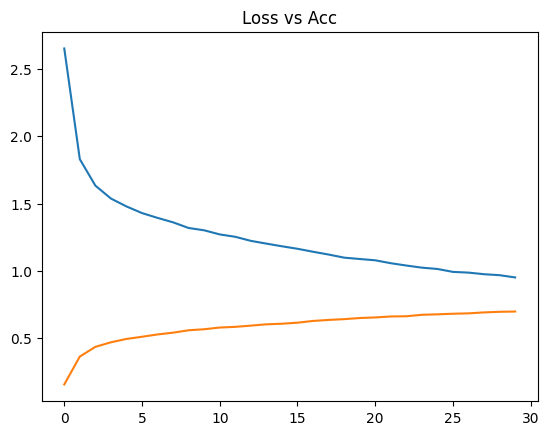

In [20]:
h = final.history
h.keys()



plt.plot(h['loss'])
plt.plot(h['accuracy'])

plt.title("Loss vs Acc")
plt.show()